# Lending Club Unbalanced Dataset : Resampling Techniques

I am using in this notebook the publicly available dataset of Lending Club (2007 to 2015 file from Kaggle). It's a real world data set with a nice mix of categorical and continuous variables.(https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/loan.csv) 

In this dataset there is a classification problem that is data imbalance between classes (Good Loans: 97.35% and Bad Loans: 2.65%) in target variable.  In the other words, the class 1 (bad loans) has significantly lower representation in the trainning data relative to class 0 (good loans). **The performance in minority class is that I care about in this work.**

### Objectives:
It is desired to have a high recall on the minority class (1) while maintaining a high precision on the majority class (0):
**Precison on 0** -> is the ratio tn / (tn + fn) where tn is the number of true negatives and fn the number of false negatives. It is intuitively the ability of the classifier not to label as bad loan (1) a value that is good loan (0). <br> 
**Recall on 1** -> is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. It is intuitively the ability of the classifier to find all the positive values (bad loans "1"). 

In this notebook, I will show a number of resampling techniques to handle unbalanced datasets and see their effect on classification performance.

For this problem I chose a classifier Random Forest that showed a good performance on the minority class. 
We will compare various techniques with respect to their effect on the recall on the minority class (1) and the precision on the majority class "0".

Since different methods of resampling work different in different data distribution, classifiers and objectives, I am going to compare modified dataset and analyse the results.


credit: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=video&cd=1&cad=rja&uact=8&ved=0ahUKEwiEx_icppXZAhWHrFQKHQ4fDT0QtwIIKjAA&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D-Z1PaqYKC1w&usg=AOvVaw30WRonWtQ9z2XAqeAYEisX

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from datetime import datetime

pd.set_option("max.columns", 100)
pd.set_option("max.colwidth", 100)

from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import binarize
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import warnings
from itable import PrettyTable, TableStyle, CellStyle
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (12,6)
plt.style.use('fivethirtyeight')




Populating the interactive namespace from numpy and matplotlib


/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
dt = pd.read_csv("loan.csv")
dt.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking a...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Values and Useless Columns at the Firts Sight
After loading the entire data set I’d like to check its structure and summarise it.

In [3]:
print "How many columns?", dt.shape[1]
print "How many rows?", dt.shape[0]

How many columns? 74
How many rows? 887379


In [4]:
#Verifying columns that have null values
keys = dt.columns
commands = ['dt.' + keys[i] + ".isnull().sum()" for i in range(len(keys))]
i = 0
n = []
for item in commands:
        n.append((keys[i], eval(item)))
        i+=1
print n

[('id', 0), ('member_id', 0), ('loan_amnt', 0), ('funded_amnt', 0), ('funded_amnt_inv', 0), ('term', 0), ('int_rate', 0), ('installment', 0), ('grade', 0), ('sub_grade', 0), ('emp_title', 51457), ('emp_length', 0), ('home_ownership', 0), ('annual_inc', 4), ('verification_status', 0), ('issue_d', 0), ('loan_status', 0), ('pymnt_plan', 0), ('url', 0), ('desc', 761350), ('purpose', 0), ('title', 151), ('zip_code', 0), ('addr_state', 0), ('dti', 0), ('delinq_2yrs', 29), ('earliest_cr_line', 29), ('inq_last_6mths', 29), ('mths_since_last_delinq', 454312), ('mths_since_last_record', 750326), ('open_acc', 29), ('pub_rec', 29), ('revol_bal', 0), ('revol_util', 502), ('total_acc', 29), ('initial_list_status', 0), ('out_prncp', 0), ('out_prncp_inv', 0), ('total_pymnt', 0), ('total_pymnt_inv', 0), ('total_rec_prncp', 0), ('total_rec_int', 0), ('total_rec_late_fee', 0), ('recoveries', 0), ('collection_recovery_fee', 0), ('last_pymnt_d', 17659), ('last_pymnt_amnt', 0), ('next_pymnt_d', 252971), ('l

In [5]:
# drop columns that have more than 700000 missing values
dr1 = []
for elem in n:
    if elem[1] > 700000:
        dr1.append(elem[0])
print dr1

['desc', 'mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


In [6]:
dt.drop(dr1, inplace=True, axis=1)

In [7]:
dt.shape

(887379, 55)

In [8]:
# drop columns that are useless at the first sight.
dr2 = ['id',
      'member_id',
     'emp_title',
     'url',
     'title',
     'purpose',
     'addr_state']
dt.drop(dr2, inplace=True, axis=1)

In [9]:
dt.shape

(887379, 48)

In [10]:
# drop rows that have any missing values
dt.dropna(how="any", inplace = True)

In [11]:
dt.shape

(161621, 48)

### Verifying Unique Values in Categorical Variables

In [12]:
obj= dt.select_dtypes(include=[object])
obj = obj.columns

In [13]:
#Verifying unique values
commands = ['dt.' + obj[i] + ".unique()" for i in range(len(obj))]
i = 0
for item in commands:
    print "* " + obj[i] + ':'
    print sorted(eval(item))[:10]
    i+=1

* term:
[' 36 months', ' 60 months']
* grade:
['A', 'B', 'C', 'D', 'E', 'F', 'G']
* sub_grade:
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5']
* emp_length:
['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years']
* home_ownership:
['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']
* verification_status:
['Not Verified', 'Source Verified', 'Verified']
* issue_d:
['Apr-2013', 'Apr-2014', 'Apr-2015', 'Aug-2012', 'Aug-2013', 'Aug-2014', 'Aug-2015', 'Dec-2012', 'Dec-2013', 'Dec-2014']
* loan_status:
['Current', 'Default', 'In Grace Period', 'Issued', 'Late (16-30 days)', 'Late (31-120 days)']
* pymnt_plan:
['n', 'y']
* zip_code:
['007xx', '010xx', '011xx', '012xx', '013xx', '014xx', '015xx', '016xx', '017xx', '018xx']
* earliest_cr_line:
['Apr-1958', 'Apr-1961', 'Apr-1962', 'Apr-1963', 'Apr-1964', 'Apr-1965', 'Apr-1966', 'Apr-1967', 'Apr-1968', 'Apr-1969']
* initial_list_status:
['f', 'w']
* last_pymnt_d:
['Aug-2015', 'De

## Understanding Categorical Variables:  encoding, dropping and transforming

#### term

[' 36 months', ' 60 months']<br>
The number of payments on the loan. Values are in months and can be either 36 or 60.
The loan grade is the result of a formula that takes into account not only credit score, but also a combination of several indicators of credit risk from the credit report and loan application. All loans have either a 36 or 60 month term, with fixed interest rates and equal payments.

In [14]:
#Encoding variable 'term'
term_dict = {' 36 months': 36, ' 60 months': 60}
dt["term"] = dt.term.map(term_dict)   

#### grade and sub_grade

grade: ['A', 'B', 'C', 'D', 'E', 'F', 'G']<br>
sub_grade: ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', <br>
            'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', <br>
            'G1', 'G2', 'G3', 'G4', 'G5'] <br>
I decided to encode just sub_grade because it is directly related to the interest rate. And I decided to drop the grade variable because it has the same information but with less detail. <br>

http://pbpython.com/categorical-encoding.html <br>
One trick you can use in pandas is to convert a column to a category, then use those category values for your label encoding:

In [15]:
dt["sub_grade"] = dt["sub_grade"].astype('category')
# Then you can assign the encoded variable to a new column using the cat.codes accessor:
dt["sub_grade_en"] = dt["sub_grade"].cat.codes
dt.drop(["sub_grade", "grade"], axis=1, inplace=True)

#### emp_length

['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'n/a'] <br>
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [16]:
emp_length_dict = {'2 years': 2, '7 years': 7, '6 years': 6, '10+ years': 10, '8 years': 8, '5 years': 5,
       '3 years': 3, '1 year': 1, '4 years': 4, '9 years': 9, '< 1 year': 0, 'n/a' : np.nan }

In [17]:
dt["emp_length"] = dt.emp_length.map(emp_length_dict)

In [18]:
dt.dropna(how="any", inplace=True)

In [19]:
dt.emp_length.unique()

array([  2.,   7.,   6.,  10.,   8.,   5.,   3.,   1.,   4.,   9.,   0.])

#### home_ownership

"home_ownership" is the home ownership status provided by the borrower during registration or obtained from the credit report. The values in Lending Club are: RENT, OWN, MORTGAGE, OTHER.<br>
Since I found in the data set ['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'], I am going to join 'ANY','NONE' and 'OTHER' in just one encoding value.

In [20]:
dt.home_ownership.replace('ANY','OTHER', inplace=True)
dt.home_ownership.replace('NONE','OTHER', inplace=True)

In [21]:
dt.home_ownership.unique()

array(['MORTGAGE', 'RENT', 'OWN', 'OTHER'], dtype=object)

In [22]:
h_o = pd.get_dummies(dt.home_ownership, prefix = "h_o")

In [23]:
dt.drop("home_ownership", axis= 1, inplace=True)
dt = pd.concat([dt, h_o], axis=1)
dt.columns = dt.columns.str.lower()

#### verification_status:

Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
['Not Verified', 'Source Verified', 'Verified']
Below are four hypothetical scenarios of verification that could occur with our prospective borrowers:
- Borrower has their income verified within an acceptable range ==> income verified;
- Borrower work at Company XYZ. LC call Company XYZ and verify that  the Borrower works there. Borrower’s loan is approved ==> "income source verified."
- Borrower is not targeted for income verification. Borrower's loan is approved ==> "income not verified.
Sice both "income verified" and "income source verified" were analyzed by LC, I decided to encode the verification_status as "0" for 'Not Verified' and 1 to 'Source Verified' and 'Verified'.

In [24]:
verification_status_dict = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 1}
dt["verification_status"] = dt.verification_status.map(verification_status_dict)   

In [25]:
dt.verification_status.unique()

array([0, 1])

#### issue_d

issue_d: The month which the loan was funded
Once this information seems not usefull for the analysis, I decided to drop this variable.

In [26]:
dt.drop("issue_d", axis=1, inplace=True)

#### loan_status

['Current', 'Default', 'In Grace Period', 'Issued', 'Late (16-30 days)', 'Late (31-120 days)']
Notice that there are different statuses which seem to indicate good payment and bad payments.
I am going to approach this as a binary classification problem, so the first step is to decide what statuses I will consider good and which bad.

loan_status:
**Current**: Loan is up to date on all outstanding payments. <br>
**Default**: Loan has not been current for 121 days or more. <br>
**In Grace Period**: Loan is past due but within the 15-day grace period. <br>
**Issued**: New loan that has passed all LendingClub reviews, received full funding, and has been issued.<br>
**Late (16-30 days)**: Loan has not been current for 16 to 30 days. <br>
**Late (31-120)**: Loan has not been current for 31 to 120 days.

If a loan was 'Default', Late (16-30 days) and Late (31-120) I  will considered it  as **Bad (0) **. On the other hand, I decided just to consider as ** Good (1)'** loan if the status is 'Current'.
Loans in a 'In Grace Period'(período de carência) and 'Issued' don't tell us nothing about the behavior of the 
borrower. Because of that I decided to drop the records with these status.

In [27]:
dt = dt[(dt.loan_status != 'Issued')&(dt.loan_status != 'In Grace Period')]

In [28]:
#Encoding variable 'loan_status'
loan_status_dict = {'Current': 0, 'Late (31-120 days)': 1 , 'Late (16-30 days)': 1 , 'Default': 1}
dt["loan_status"] = dt.loan_status.map(loan_status_dict)

In [29]:
dt.loan_status.unique()

array([0, 1])

#### pymnt_plan

['n', 'y']
Indicates if a payment plan has been put in place for the loan.<br> (tipo renegociação)
In some cases, LC arranges payment plans with borrowers to bring their loans back to current status over a longer period of time. If LendingClub enters into such an agreement, details of the payment plan will be available on the loan performance page in your investor account. 
Keep in mind that loans on a payment plan may perform differently than other loans with the same status.

In [30]:
pymnt_plan_dict = {'y': 0, 'n': 1}
dt["pymnt_plan"] = dt.pymnt_plan.map(pymnt_plan_dict)

In [31]:
dt.pymnt_plan.unique()

array([1, 0])

#### zip_code

The first 3 numbers of the zip code provided by the borrower in the loan application.
Zip_code is not immediately usable in machine learning, since there are many zip codes, expanding them into boolean columns will not be effective.
So, I decided to drop this variable.

In [32]:
dt.drop("zip_code", axis=1, inplace=True)

#### earliest_cr_line

The month the borrower's earliest reported credit line was opened. 
It describes the length of time since the first line of credit. It is good variable to mesure the longer you've had lines of credit the better. It is a good variable to measure the behavior of a good payer. 

In [33]:
# melhorar
from datetime import datetime
dt.earliest_cr_line = pd.to_datetime(dt.earliest_cr_line)
dttoday = datetime.now().strftime('%Y-%m-%d')
# There is a better way to do this :) 
dt.earliest_cr_line = dt.earliest_cr_line.apply(lambda x: (
        np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

#### initial_list_status

['f', 'w']
The initial listing status of the loan. Possible values are:
- W(Whole): loans that were picked up by lenders as 'whole' loans;
- F(Fractional): loans that were picked up by lenders as 'Fractional' loans.


In [34]:
dt.initial_list_status.value_counts()

w    84138
f    66119
Name: initial_list_status, dtype: int64

In [35]:
initial_list_status_dict = {'f': 0, 'w': 1}
dt["initial_list_status"] = dt.initial_list_status.map(initial_list_status_dict)

#### last_pymnt_d, next_pymnt_d and last_credit_pull_d

It seems that this variables are not useful, so I decided to drop them.
last_pymnt_d: Last total payment amount received. 
next_pymnt_d: Next scheduled payment date;
last_credit_pull_d: the most recent month that LC pulled credit for this loan


In [36]:
dt.drop("last_pymnt_d", axis = 1, inplace = True)

In [37]:
#depois juntar com o drop de cima.
dt.drop(["next_pymnt_d","last_credit_pull_d"], axis = 1, inplace = True)

#### application_type:

['INDIVIDUAL', 'JOINT']<br>
Indicates whether the loan is an individual application or a joint application with two co-borrowers.

In [38]:
dt.application_type.value_counts()

INDIVIDUAL    150171
JOINT             86
Name: application_type, dtype: int64

In [39]:
application_type_dict = {'INDIVIDUAL': 1, 'JOINT': 0}
dt["application_type"] = dt.application_type.map(application_type_dict)

In [40]:
## The others variables wiil be avalute only in Features Selections

## Feature Selections

In [41]:
# For feature selection I am going to start with Adaboost and I am going to use manual selection, too.

In [42]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150257 entries, 42539 to 887377
Data columns (total 45 columns):
loan_amnt                      150257 non-null float64
funded_amnt                    150257 non-null float64
funded_amnt_inv                150257 non-null float64
term                           150257 non-null int64
int_rate                       150257 non-null float64
installment                    150257 non-null float64
emp_length                     150257 non-null float64
annual_inc                     150257 non-null float64
verification_status            150257 non-null int64
loan_status                    150257 non-null int64
pymnt_plan                     150257 non-null int64
dti                            150257 non-null float64
delinq_2yrs                    150257 non-null float64
earliest_cr_line               150257 non-null int64
inq_last_6mths                 150257 non-null float64
mths_since_last_delinq         150257 non-null float64
open_acc       

In [43]:
dt.to_csv('dt.csv', index=False)

In [44]:
dt = pd.read_csv('dt.csv')

In [45]:
dt.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,sub_grade_en,h_o_mortgage,h_o_other,h_o_own,h_o_rent
0,15000.0,15000.0,15000.0,36,8.90,476.30,2.0,63000.0,0,0,1,16.51,0.0,19,0.0,34.0,8.0,0.0,11431.0,74.2,29.0,1,5449.27,5449.27,11431.20,11431.20,9550.73,1880.47,0.0,0.0,0.0,476.30,0.0,34.0,1.0,1,0.0,1514.0,272492.0,15400.0,4,1,0,0,0
1,10000.0,10000.0,10000.0,36,9.67,321.13,7.0,102000.0,0,0,1,15.55,2.0,28,0.0,11.0,9.0,0.0,9912.0,44.4,22.0,0,3659.12,3659.12,7706.81,7706.81,6340.88,1365.93,0.0,0.0,0.0,321.13,0.0,54.0,1.0,1,0.0,0.0,39143.0,22300.0,5,1,0,0,0
2,27600.0,27600.0,27600.0,60,19.97,730.78,6.0,73000.0,1,0,1,23.13,1.0,28,1.0,7.0,10.0,0.0,27003.0,82.8,24.0,0,19671.64,19671.64,17538.17,17538.17,7928.36,9609.81,0.0,0.0,0.0,730.78,0.0,7.0,1.0,1,0.0,0.0,241609.0,32600.0,19,1,0,0,0
3,11100.0,11100.0,11100.0,36,14.98,384.68,10.0,90000.0,0,0,1,3.73,1.0,16,0.0,16.0,9.0,0.0,6619.0,66.2,12.0,0,4262.60,4262.60,9231.84,9231.84,6837.40,2394.44,0.0,0.0,0.0,384.68,0.0,16.0,1.0,1,0.0,0.0,353402.0,10000.0,12,1,0,0,0
4,4500.0,4500.0,4500.0,36,19.22,165.46,10.0,105000.0,0,0,1,16.23,1.0,27,0.0,10.0,5.0,0.0,19090.0,93.1,10.0,0,1793.21,1793.21,3970.85,3970.85,2706.79,1264.06,0.0,0.0,0.0,165.46,0.0,33.0,1.0,1,0.0,0.0,40100.0,20500.0,18,0,0,0,1


In [46]:
#Assign features to variable X
Xi = dt.drop("loan_status", axis = 1)
#Assign target column to variable y
y = dt.loan_status

In [47]:
#Grid AdaBoot
n_estimators_range = range(50, 200, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(Xi, y)
print grid_dt.best_params_

{'n_estimators': 100}


In [48]:
# Adaboost
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(Xi,y)
y_pred = ada.predict(Xi)
importances = sorted(zip(ada.feature_importances_, Xi), key = lambda x: x[0], reverse = True)
importances

[(0.13, 'total_rec_int'),
 (0.12, 'int_rate'),
 (0.089999999999999997, 'sub_grade_en'),
 (0.080000000000000002, 'total_rec_prncp'),
 (0.070000000000000007, 'last_pymnt_amnt'),
 (0.059999999999999998, 'dti'),
 (0.050000000000000003, 'out_prncp'),
 (0.040000000000000001, 'total_acc'),
 (0.040000000000000001, 'total_rev_hi_lim'),
 (0.029999999999999999, 'installment'),
 (0.029999999999999999, 'open_acc'),
 (0.029999999999999999, 'revol_util'),
 (0.029999999999999999, 'out_prncp_inv'),
 (0.02, 'funded_amnt_inv'),
 (0.02, 'term'),
 (0.02, 'mths_since_last_delinq'),
 (0.02, 'revol_bal'),
 (0.02, 'total_rec_late_fee'),
 (0.02, 'mths_since_last_major_derog'),
 (0.01, 'emp_length'),
 (0.01, 'annual_inc'),
 (0.01, 'earliest_cr_line'),
 (0.01, 'inq_last_6mths'),
 (0.01, 'initial_list_status'),
 (0.01, 'tot_coll_amt'),
 (0.01, 'tot_cur_bal'),
 (0.01, 'h_o_mortgage'),
 (0.0, 'loan_amnt'),
 (0.0, 'funded_amnt'),
 (0.0, 'verification_status'),
 (0.0, 'pymnt_plan'),
 (0.0, 'delinq_2yrs'),
 (0.0, 'pub_

In [49]:
importances = sorted(zip(ada.feature_importances_, Xi), key = lambda x: x[0], reverse = True)
lista = [elem[1] for elem in importances]

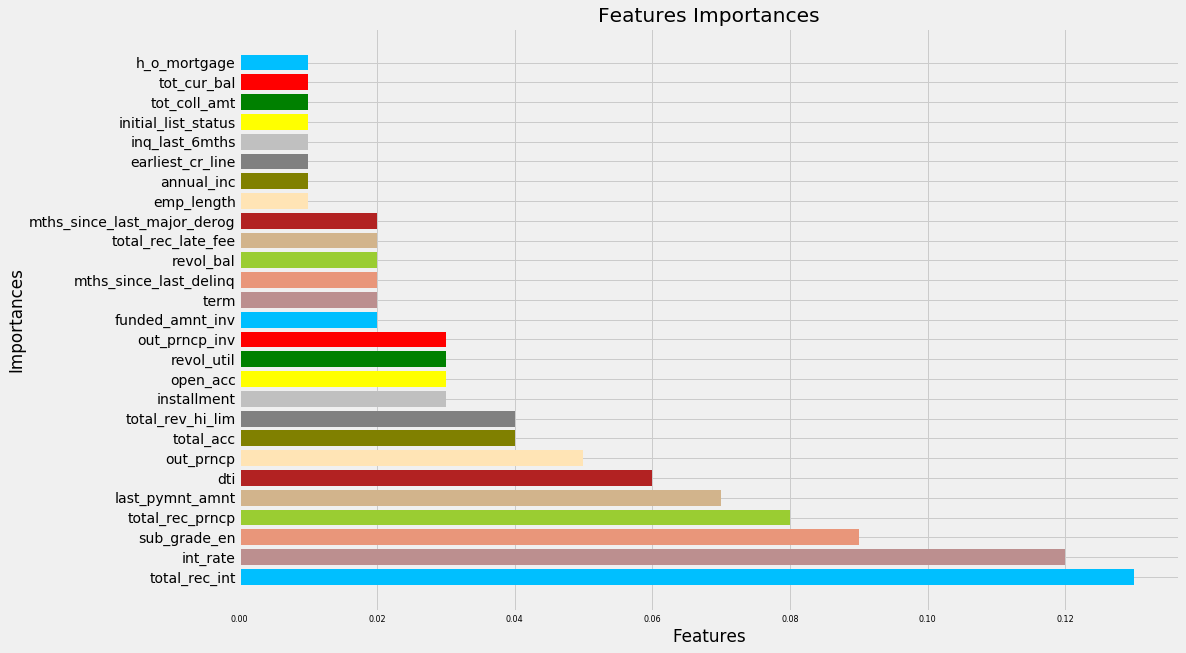

In [50]:
label = []
val = []
for i, elem in importances[:27]:
    label.append(elem)
    val.append(i)
        
label_ = label
pos = range(1,len(importances[:27])+1)
colors = ['deepskyblue', 'rosybrown', 'darksalmon', 'yellowgreen', 'tan', 'firebrick', 'moccasin', 'olive', 
          'grey', 'silver', 'yellow', 'green', 'red']
          
w = 0.8

#Matplotlib
plt.figure(figsize = (15,10))
plt.barh(pos, width=val, height=w, color = colors, tick_label = label_,  align="center")
plt.ylabel("Importances")
plt.xticks(rotation=0, size="xx-small")
plt.xlabel("Features")
plt.title("Features Importances")
plt.show()


In [51]:
# I am going to drop variables that the feature importances are 0.0.
dp = ['loan_amnt',
    'funded_amnt',
    'verification_status',
    'pymnt_plan',
    'delinq_2yrs',
    'pub_rec',
    'total_pymnt',
    'total_pymnt_inv',
    'recoveries',
    'collection_recovery_fee',
    'collections_12_mths_ex_med',
    'policy_code',
    'application_type',
    'acc_now_delinq',
    'h_o_other',
    'h_o_own',
    'h_o_rent']
dt.drop(dp, axis=1, inplace=True)

In [52]:
dt.shape

(150257, 28)

In [53]:
#Assign features to variable X
Xi = dt.drop("loan_status", axis=1)
#Assign target column to variable y
y = dt.loan_status

In [54]:
ss = StandardScaler()
X = ss.fit_transform(Xi)

In [55]:
pca = PCA(n_components=2) 
X = pca.fit_transform(X)

In [56]:
#Null accuracy
y.value_counts(normalize=True)*100

0    97.351205
1     2.648795
Name: loan_status, dtype: float64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [58]:
X.shape[1]

2

In [59]:
target_names =["Good Loans (0)", "Good Loans (1)"]

In [60]:
n1 = "Random undersampling of majority class"
us = RandomUnderSampler(ratio=0.5, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 5990, 1: 2995})


In [61]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)


Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.86      0.91     36580
          1       0.04      0.22      0.07       985

avg / total       0.95      0.84      0.89     37565

[[31483  5097]
 [  768   217]]


In [62]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,31483,FP,5097,36580
corr1,FN,768,TP,217,985
total,,32251,,5314,37565


In [63]:
report = classification_report(y_test,y_pred)
lines = report.split()
p_r_ = []
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report


,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]


print round(23753/float(23753+396),2)
print round(589/float(589+396),2)

In [64]:
n2 = "Near Miss 1"
us = NearMiss(ratio=0.5, size_ngh=3, version=1, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 5990, 1: 2995})


In [65]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)


Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      0.28      0.44     36580
          1       0.03      0.72      0.05       985

avg / total       0.95      0.29      0.43     37565

[[10305 26275]
 [  278   707]]


In [66]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,10305,FP,26275,36580
corr1,FN,278,TP,707,985
total,,10583,,26982,37565


In [67]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))
cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report


,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]


In [68]:
n3 = "Near Miss 2"
us = NearMiss(ratio=0.5, size_ngh=3, version=2, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 5990, 1: 2995})


In [69]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.07      0.13     36580
          1       0.03      0.96      0.05       985

avg / total       0.96      0.09      0.12     37565

[[ 2445 34135]
 [   42   943]]


In [70]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,2445,FP,34135,36580
corr1,FN,42,TP,943,985
total,,2487,,35078,37565


In [71]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report


,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]


In [72]:
n4 = "Near Miss 3"
us = NearMiss(ratio=0.5, size_ngh=3, ver3_samp_ngh=3, version=3, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 5990, 1: 2995})


/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'ver3_samp_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors_ver3' instead.
  category=DeprecationWarning)


In [73]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      0.84      0.90     36580
          1       0.03      0.17      0.05       985

avg / total       0.95      0.82      0.88     37565

[[30768  5812]
 [  822   163]]


In [74]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,30768,FP,5812,36580
corr1,FN,822,TP,163,985
total,,31590,,5975,37565


In [75]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]


In [76]:
n5 = "Tomek link removal"
us = TomekLinks(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 107930, 1: 2995})


In [77]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      1.00      0.99     36580
          1       0.07      0.00      0.01       985

avg / total       0.95      0.97      0.96     37565

[[36542    38]
 [  982     3]]


In [78]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,36542,FP,38,36580
corr1,FN,982,TP,3,985
total,,37524,,41,37565


In [79]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]


In [80]:
n6 = "Edited Nearest Neighbor (ENN)"
us = EditedNearestNeighbours(size_ngh=5, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 96301, 1: 2995})


In [81]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98     36580
          1       0.07      0.02      0.03       985

avg / total       0.95      0.97      0.96     37565

[[36334   246]
 [  966    19]]


In [82]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,36334,FP,246,36580
corr1,FN,966,TP,19,985
total,,37300,,265,37565


In [83]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]


In [84]:
n7 =  "Repeated Edited Nearest Neighbor"
us = RepeatedEditedNearestNeighbours(size_ngh=5, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 97624, 1: 2995})


In [85]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98     36580
          1       0.08      0.02      0.04       985

avg / total       0.95      0.97      0.96     37565

[[36326   254]
 [  962    23]]


In [86]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,36326,FP,254,36580
corr1,FN,962,TP,23,985
total,,37288,,277,37565


In [87]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6, n7]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]
Repeated Edited Nearest Neighbor,[0.97],[0.02]


In [88]:
n8 = "Random oversampling of minority class"
os = RandomOverSampler(ratio=0.5, random_state=1) 
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 109697, 1: 54848})


In [89]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98     36580
          1       0.08      0.02      0.03       985

avg / total       0.95      0.97      0.96     37565

[[36336   244]
 [  964    21]]


In [90]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,36336,FP,244,36580
corr1,FN,964,TP,21,985
total,,37300,,265,37565


In [91]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6, n7, n8]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]
Repeated Edited Nearest Neighbor,[0.97],[0.02]
Random oversampling of minority class,[0.97],[0.02]


In [92]:
n9 = "Synthetic Minority Oversampling Technique (SMOTE)"
os = SMOTE(ratio=0.5, k=5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 109697, 1: 54848})


In [93]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.88      0.92     36580
          1       0.04      0.17      0.06       985

avg / total       0.95      0.86      0.90     37565

[[32090  4490]
 [  814   171]]


In [94]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,32090,FP,4490,36580
corr1,FN,814,TP,171,985
total,,32904,,4661,37565


In [95]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6, n7, n8, n9]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]
Repeated Edited Nearest Neighbor,[0.97],[0.02]
Random oversampling of minority class,[0.97],[0.02]
Synthetic Minority Oversampling Technique (SMOTE),[0.98],[0.17]


In [96]:
n10 = "SMOTE + Tomek link removal"
os_us = SMOTETomek(ratio=0.5, k=5, random_state=1) 
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_tomek.py:174: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 101992, 1: 47143})


In [97]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.88      0.92     36580
          1       0.04      0.18      0.06       985

avg / total       0.95      0.86      0.90     37565

[[32121  4459]
 [  803   182]]


In [98]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,32121,FP,4459,36580
corr1,FN,803,TP,182,985
total,,32924,,4641,37565


In [99]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6, n7, n8, n9, n10]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]
Repeated Edited Nearest Neighbor,[0.97],[0.02]
Random oversampling of minority class,[0.97],[0.02]
Synthetic Minority Oversampling Technique (SMOTE),[0.98],[0.17]
SMOTE + Tomek link removal,[0.98],[0.18]


In [100]:
n11 =  "SMOTE + ENN"
os_us = SMOTEENN(ratio=0.5, k=5, size_ngh=5, random_state=1) 
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_enn.py:224: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/combine/smote_enn.py:251: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a ENN object instead.
  DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: D

Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 66052, 1: 18171})


In [101]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)



Accuracy: 0.97 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.89      0.93     36580
          1       0.05      0.20      0.08       985

avg / total       0.95      0.87      0.91     37565

[[32617  3963]
 [  788   197]]


In [102]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,32617,FP,3963,36580
corr1,FN,788,TP,197,985
total,,33405,,4160,37565


In [103]:
report = classification_report(y_test,y_pred)
lines = report.split()
cr = []
for line in lines:
    row_data = line.split()
    cr.append(row_data)
p_r_.append((cr[5], cr[11]))

cols = ["Precision on 0", "Recall on 1"]
index = [n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11]
report = pd.DataFrame(p_r_, columns=cols, index=index)
report

,Precision on 0,Recall on 1
Random undersampling of majority class,[0.98],[0.22]
Near Miss 1,[0.97],[0.72]
Near Miss 2,[0.98],[0.96]
Near Miss 3,[0.97],[0.17]
Tomek link removal,[0.97],[0.00]
Edited Nearest Neighbor (ENN),[0.97],[0.02]
Repeated Edited Nearest Neighbor,[0.97],[0.02]
Random oversampling of minority class,[0.97],[0.02]
Synthetic Minority Oversampling Technique (SMOTE),[0.98],[0.17]
SMOTE + Tomek link removal,[0.98],[0.18]


## Best Performance: Near Miss 2 + Random Forest Classifier

In [105]:
# Near Miss 2
us = NearMiss(ratio=0.5, size_ngh=3, version=2, random_state=1) 
X_train_res, y_train_res = us.fit_sample(X_train, y_train)
print "Distribution of class labels before resampling {}".format(Counter(y_train)) 
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 109697, 1: 2995})
Distribution of class labels after resampling Counter({0: 5990, 1: 2995})


In [106]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train_res, y_train_res)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train_res,y_train_res)
y_pred = rf.predict(X_test)                
scores = cross_val_score(rf, X_test, y_test, cv=5)
print "Accuracy: %0.4f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

Accuracy: 0.9718 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.98      0.07      0.12     36580
          1       0.03      0.96      0.05       985

avg / total       0.96      0.09      0.12     37565

[[ 2441 34139]
 [   43   942]]


In [107]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
cm_df

,,pred0,,pred1,total
corr0,TN,2441,FP,34139,36580
corr1,FN,43,TP,942,985
total,,2484,,35081,37565


## CONCLUSION

In this notebook I showed some resampling techniques to improve classification performance on the minority class in the presence of data imbalance. I presented the performance of several methods on a dataset in terms of precision on the majority class and recall on the minority class.<br>
On our dataset, with respect to our chosen metric, the methods Near Miss 2 in combination with a Random Forest Classifier give the best performance. <br>
However, depending on the data distribution, the presence of class imbalance, the choice of classifier used on resampled datasets may yield better results.